In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Copyright 2022 Peter Wu
#  MIT License (https://opensource.org/licenses/MIT)

"""Demo for speech-to-EMA and EMA-to-speech models."""

import os
import IPython

import numpy as np
import soundfile as sf
import torch
import yaml

from tqdm import tqdm

from ats.bin.decode import ar_loop
from ats.utils import load_model


/home/peter/anaconda3/envs/articulatory/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Speech-to-EMA

In [2]:
# Load Speech-to-EMA model
inversion_checkpoint_path = "../exp/mocha_train_lcdx0pmf8nema_w2mocha_hifi_lcdx0pm/best_mel_ckpt.pkl"
inversion_config_path = "../exp/mocha_train_lcdx0pmf8nema_w2mocha_hifi_lcdx0pm/config.yml"

# load config
with open(inversion_config_path) as f:
    inversion_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    inversion_device = torch.device("cuda")
else:
    inversion_device = torch.device("cpu")
inversion_model = load_model(inversion_checkpoint_path, inversion_config)
inversion_model.remove_weight_norm()
inversion_model = inversion_model.eval().to(inversion_device)

In [3]:
# Predict EMA sequence for given speech
# input_wav_path = '../downloads/emadata/cin_us_faet0/wav/faet0_009.wav'
input_wav_path = '../downloads/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_slt_arctic/wav/arctic_a0001.wav'
output_art_path = None
    # NOTE change None to file path if want to save predicted EMA sequence

audio, sr = sf.read(input_wav_path)

with torch.no_grad():
    audio = torch.tensor(audio, dtype=torch.float).to(inversion_device)
    pred = ar_loop(inversion_model, audio, inversion_config)
    if output_art_path is not None:
        np.save(output_art_path, pred.cpu().numpy())


In [4]:
pred.cpu().numpy().shape

(800, 40)

In [5]:
np.save('arctic_a0001_palate.npy', pred.cpu().numpy())

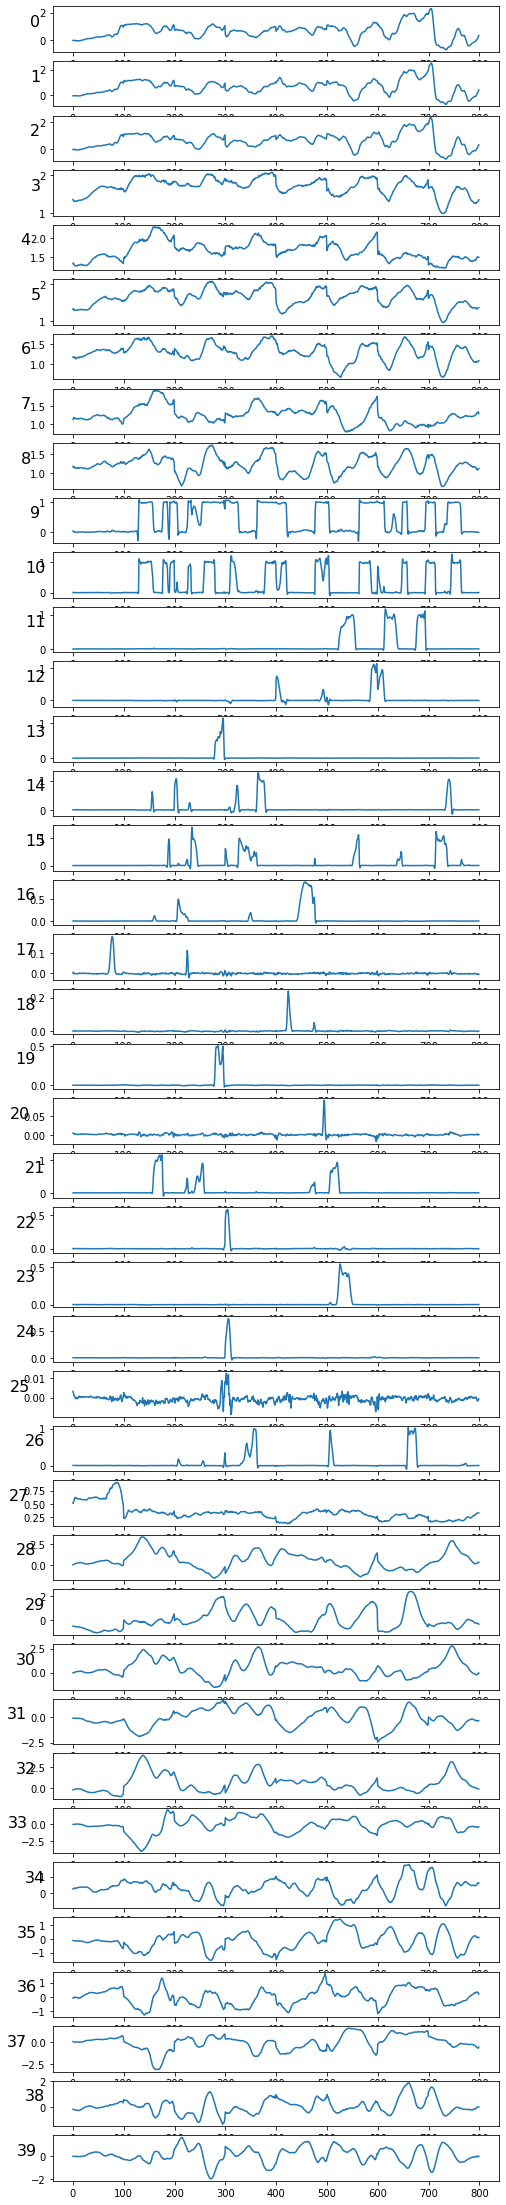

In [5]:
# plot estimated EMA sequence
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=pred.shape[1], ncols=1, figsize=(8,pred.shape[1]))
for art_i in range(pred.shape[1]):
      axes[art_i].plot(pred.cpu().numpy()[:, art_i])
      axes[art_i].set_ylabel('%d' % art_i, fontsize=16, rotation=0)
plt.savefig('arctic_a0001_palate.png')

# EMA-to-Speech

In [6]:
# Load EMA-to-Speech model
synthesis_checkpoint_path = "../exp/mocha_train_lcdx0pmf8nema_mocha2w_hifi_lcdx0pm/best_mel_ckpt.pkl"
synthesis_config_path = "../exp/mocha_train_lcdx0pmf8nema_mocha2w_hifi_lcdx0pm/config.yml"
# synthesis_checkpoint_path = "../exp/mocha2w_hifi_lcdx0pm_2k/best_mel_ckpt.pkl"
# synthesis_config_path = "../exp/mocha2w_hifi_lcdx0pm_2k/config.yml"

# load config
with open(synthesis_config_path) as f:
    synthesis_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    synthesis_device = torch.device("cuda")
else:
    synthesis_device = torch.device("cpu")
synthesis_model = load_model(synthesis_checkpoint_path, synthesis_config)
synthesis_model.remove_weight_norm()
synthesis_model = synthesis_model.eval().to(synthesis_device)

In [7]:
# Predict waveform for given EMA sequence
output_wav_path = "arctic_a0001_palate.wav"

with torch.no_grad():
    c = torch.tensor(pred, dtype=torch.float).to(synthesis_device)
    y = ar_loop(synthesis_model, c, synthesis_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        synthesis_config["sampling_rate"],
        "PCM_16",
    )


/tmp/ipykernel_106641/980940094.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(pred, dtype=torch.float).to(synthesis_device)


In [20]:
IPython.display.Audio(output_wav_path)
